In [ ]:
# First cell - imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from process import (pad_and_resize, generate_masks, apply_mask, 
                    get_hair_patch, enhance_contrast, write_mask)
import sys

# Clear any existing command line args to prevent conflicts with Jupyter
sys.argv = [sys.argv[0]]

In [12]:
# Second cell - options class
class ProcessOptions:
    def __init__(self):
        self.input_dir = "path/to/input/dir"
        self.output_dir = "path/to/output/dir"
        self.model_type_sam = "vit_h"  # or your SAM model type
        self.checkpoint_sam = "path/to/sam/checkpoint.pth"
        self.image_size = 1024
        self.patch_size = 256
        self.clahe_clip_limit = 2.0
        self.clahe_grid_size = 8
        self.skip_mask_generation = False
        self.skip_patch_extraction = False
        self.skip_contrast_enhancement = False

opt = ProcessOptions()

In [14]:
# Third cell - visualization function
def visualize_transformation_pipeline(image_path, opt):
    """Visualize each step of the image transformation pipeline."""
    
    # Read original image
    original = cv2.imread(image_path)
    if original is None:
        print(f"Could not load image: {image_path}")
        return
    
    # Convert BGR to RGB for display
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Get resized image (ensure it's RGB)
    resized = pad_and_resize(original, opt.image_size)
    
    # Make a BGR copy for processing
    resized_bgr = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)
    
    # Initialize SAM and generate masks
    print("Initializing SAM model...")
    sam = sam_model_registry[opt.model_type_sam](checkpoint=opt.checkpoint_sam)
    sam.to(device="cpu")
    predictor = SamPredictor(sam)
    
    # Generate masks using the BGR version
    hair_masks, _ = generate_masks(image_path, None, predictor)
    
    # Convert mask to proper format and apply it
    if hair_masks is not None:
        # Save mask temporarily
        temp_mask_path = "temp_mask.png"
        write_mask(hair_masks, temp_mask_path)
        
        # Read mask and ensure it's the right size
        hair_mask = cv2.imread(temp_mask_path, cv2.IMREAD_GRAYSCALE)
        if hair_mask.shape[:2] != (opt.image_size, opt.image_size):
            hair_mask = cv2.resize(hair_mask, (opt.image_size, opt.image_size))
        
        # Apply mask
        masked = apply_mask(resized_bgr, hair_mask)
        
        # Get hair patch
        patch = get_hair_patch(masked, hair_mask, opt.patch_size)
        
        # Enhance patch if available
        if patch is not None:
            enhanced = enhance_contrast(
                patch,
                opt.clahe_clip_limit,
                opt.clahe_grid_size
            )
        else:
            print("No valid hair patch found")
            enhanced = np.zeros((opt.patch_size, opt.patch_size, 3), dtype=np.uint8)
        
        # Clean up temporary file
        os.remove(temp_mask_path)
    else:
        print("No hair mask generated")
        return

    # Create figure with subplots
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle('Image Transformation Pipeline', fontsize=16)

    # Plot images
    axes[0].imshow(original)
    axes[0].set_title(f'Original {original.shape}')
    
    axes[1].imshow(resized)
    axes[1].set_title(f'Resized {resized.shape}')
    
    axes[2].imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'Masked {masked.shape}')
    
    if patch is not None:
        axes[3].imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        axes[3].set_title(f'Hair Patch {patch.shape}')
        
        axes[4].imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
        axes[4].set_title(f'Enhanced Patch {enhanced.shape}')
    else:
        axes[3].imshow(np.zeros((opt.patch_size, opt.patch_size, 3)))
        axes[3].set_title('No Hair Patch')
        axes[4].imshow(np.zeros((opt.patch_size, opt.patch_size, 3)))
        axes[4].set_title('No Enhanced Patch')
    
    # Remove axes
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print shapes for debugging
    print(f"\nImage shapes:")
    print(f"Original: {original.shape}")
    print(f"Resized: {resized.shape}")
    print(f"Mask: {hair_mask.shape}")
    print(f"Masked: {masked.shape}")
    if patch is not None:
        print(f"Patch: {patch.shape}")
        print(f"Enhanced: {enhanced.shape}")

Initializing SAM model...


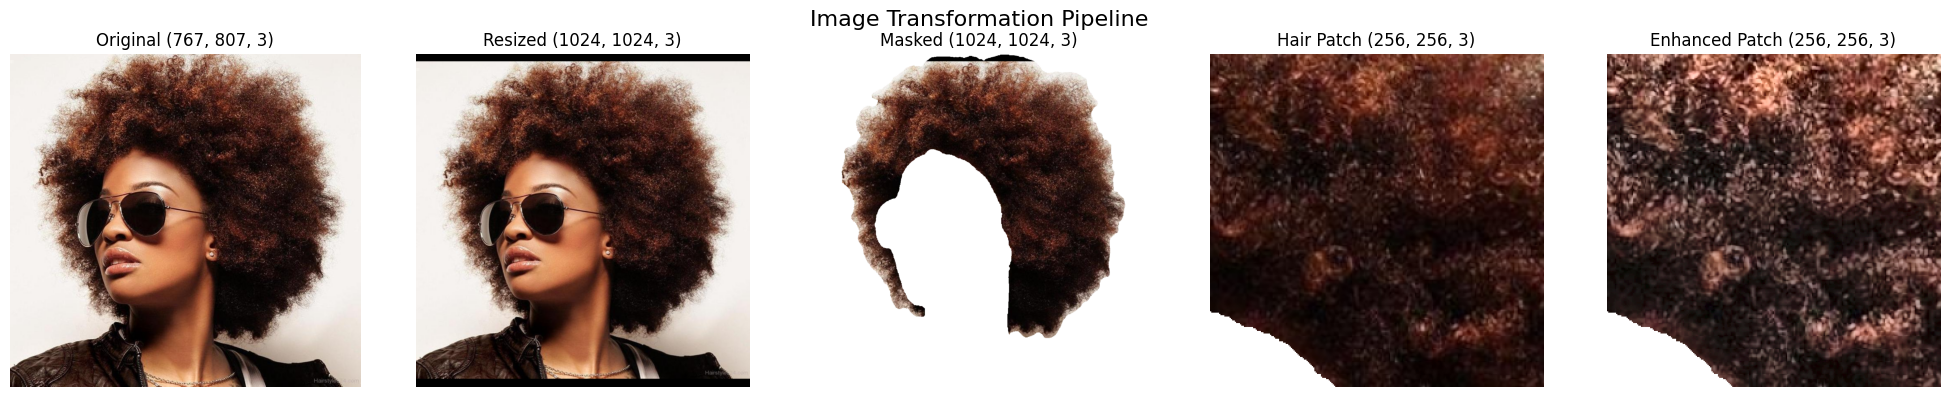


Image shapes:
Original: (767, 807, 3)
Resized: (1024, 1024, 3)
Mask: (1024, 1024)
Masked: (1024, 1024, 3)
Patch: (256, 256, 3)
Enhanced: (256, 256, 3)


In [16]:
# Fourth cell - run visualization
# Update these paths for your environment
opt.checkpoint_sam = "/Users/nickrui/Desktop/HairType/checkpoints/sam_vit_h_4b8939.pth"  # Update with your SAM checkpoint path
image_path = "/Users/nickrui/Desktop/HairType/images/raw_images/Frame00498-org.jpg"  # Update with your test image path

# Run visualization
visualize_transformation_pipeline(image_path, opt)